In [1]:
from awpy import Demo

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader, HeteroData
from torch_geometric.loader import DataLoader

import pandas as pd
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import shap
shap.initjs()

from PIL import Image

import time
import json
import sys
import os

pd.set_option('display.max_columns', 100)
pd.set_option('future.no_silent_downcasting', True)

pl.Config.set_tbl_rows(10)
pd.set_option('display.max_columns', 50)

sys.path.append(os.path.abspath('../../package'))

from CS2.graph import TabularGraphSnapshot, HeteroGraphSnapshot, TemporalHeteroGraphSnapshot
from CS2.token import Tokenizer
from CS2.preprocess import Dictionary, NormalizePosition, NormalizeTabularGraphSnapshot, ImputeTabularGraphSnapshot
from CS2.visualize import HeteroGraphVisualizer
from CS2.analyze import SnapshotEvents, HeteroGNNRoundAnalyzer

PATH_TAB_DATA = '../../data/matches-processed/cs2/tabular/2023/'
PATH_GRAPH_DATA = '../../data/matches-processed/cs2/hetero-graph/'
PATH_TEMP_GRAPH_DATA = '../../data/matches-processed/cs2/temporal-hetero-graph/temporal-hetero-graph_20/'
PATH_MODELS = '../../model/tgn/'



class CSTemporalDataLoader(DataLoader):

    def __init__(self, dataset, batch_size=1, shuffle=False, *args, **kwargs):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, *args, **kwargs)

        self._dataset = dataset
        self._batch_size = batch_size
        self._shuffle = shuffle

    def __iter__(self):
        # Optionally shuffle the dataset
        indices = list(range(len(self._dataset)))
        if self._shuffle:
            torch.random.manual_seed(42)  # Ensure reproducibility if needed
            indices = torch.randperm(len(self._dataset)).tolist()

        # Yield batches of DTDGs
        batch = []
        for idx in indices:
            batch.append(self._dataset[idx])
            if len(batch) == self._batch_size:
                yield batch
                batch = []

        # Yield the last smaller batch if it exists
        if batch:
            yield batch


C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data and model

In [2]:
# Data
data = torch.load(PATH_GRAPH_DATA + '100000.pt', weights_only=False)
temp_data = torch.load(PATH_TEMP_GRAPH_DATA + '100000.pt', weights_only=False)


# Load Model Code
model_class_code = ''
with open(PATH_MODELS + '241025_3_best/' + 'gnn_code.txt', 'r') as f:
    model_class_code = f.read()
exec(model_class_code)

# Load Model
model = torch.load(PATH_MODELS + '/241025_3_best/epoch_1.pt', weights_only=False)

## Analyze

In [ ]:
round_number = 7

analyzer = HeteroGNNRoundAnalyzer(graphs=data, dyn_graphs=temp_data, model=model, round_number=round_number)

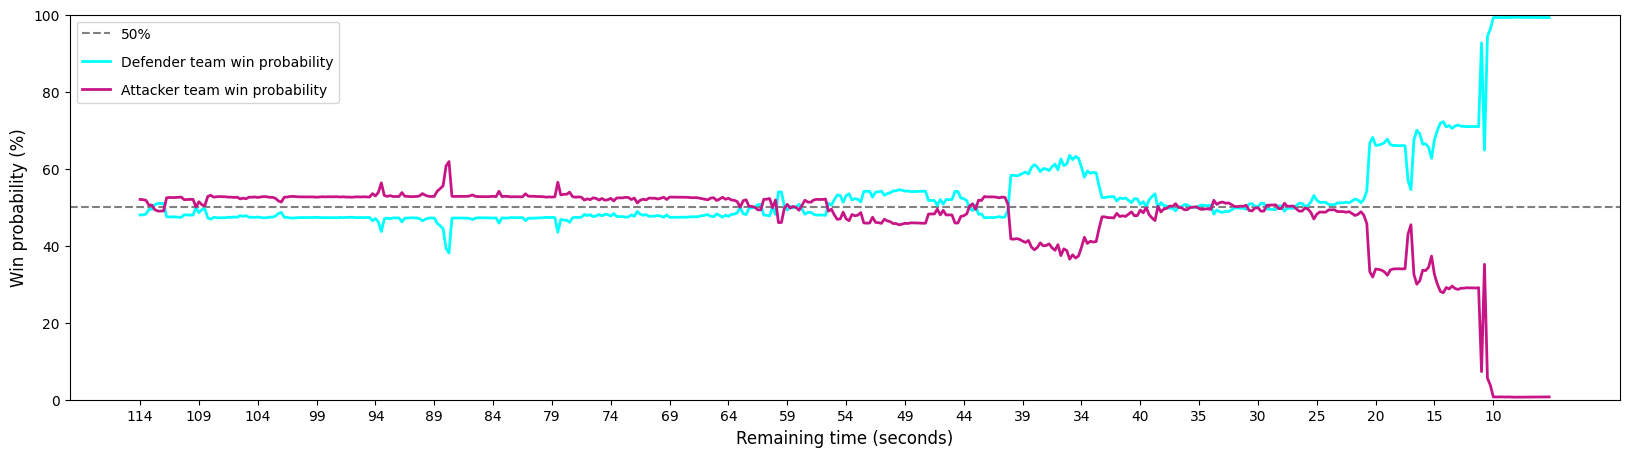

In [4]:
analyzer.predict_proba()

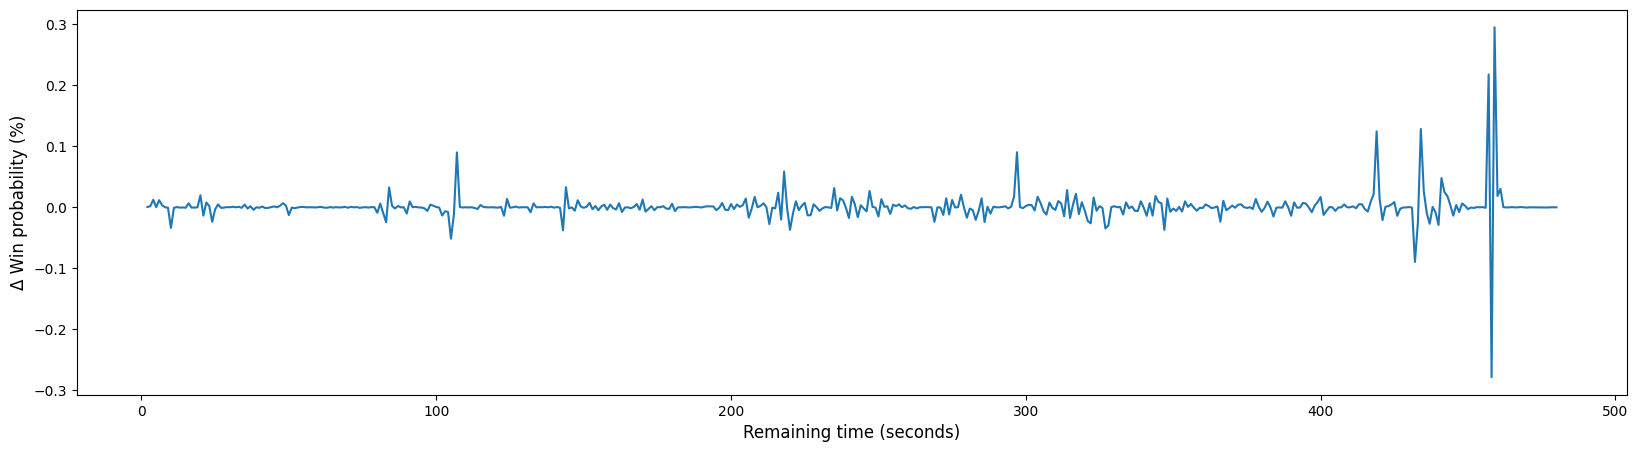

In [5]:
analyzer.delta_proba()

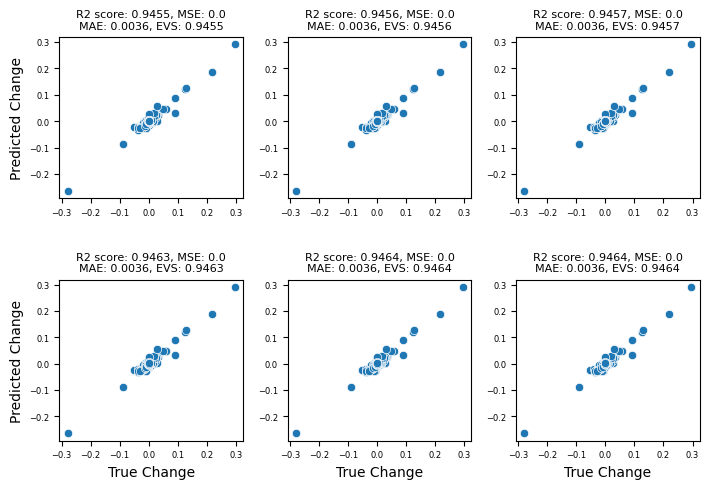

In [6]:
analyzer.plot_local_preds()

In [4]:
analyzer.feature_importance()

,CT features,importance,CT features,importance
0,CT3_is_defusing_change,0.187047,CT4_ammo_left_percent_change,-0.075012
1,CT4_active_weapon_AK-47_change,0.105218,bomb_on_B_change,-0.062891
2,CT4_health_change,0.066528,T5_health_change,-0.043112
3,CT2_vel_Y_change,0.044777,T5_armor_change,-0.043112
4,CT2_b_change,0.043112,T5_is_alive_change,-0.043112
5,T7_inventory_C4_change,0.036451,T5_inventory_Glock-18_change,-0.043112
6,CT2_active_weapon_AWP_change,0.034929,T5_inventory_AK-47_change,-0.043112
7,CT4_active_weapon_Smoke Grenade_change,0.033074,T6_health_change,-0.037473
8,T8_vel_Y_change,0.031340,CT2_ammo_left_percent_change,-0.031811
9,T5_inventory_Flashbang_change,0.027210,T6_armor_change,-0.031757


#### SHAP

In [4]:
shap_values, explainer_expected_value = analyzer.get_shap_values()

In [11]:
start_idx = 0
end_idx = len(shap_values)

start_idx = 205
end_idx = 225

shap.force_plot(explainer_expected_value, shap_values[start_idx:end_idx, :], analyzer.edf_1.drop(columns=['y_change', 'idx', 'y', 'round_change', 'round']).iloc[start_idx:end_idx, :])